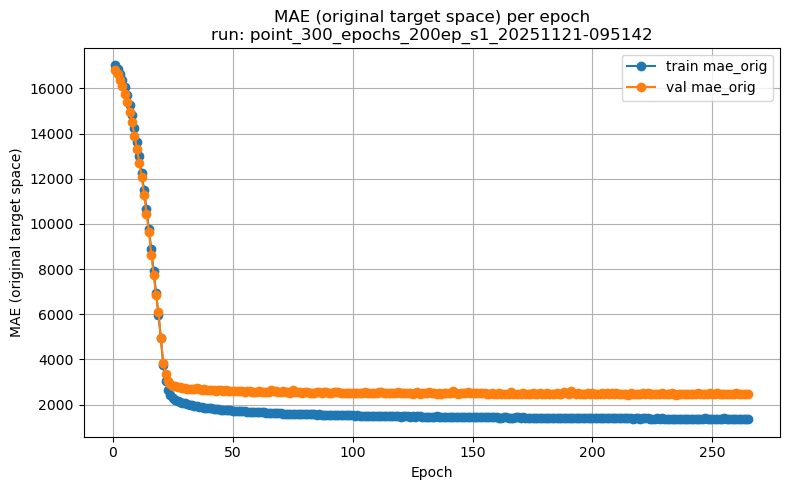

In [ ]:
# === Cell: Plot train vs validation curve for a selected metric ===
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# User config
# ------------------------------------------------------------------
# 1) Training run directory: folder that contains metrics.csv
RUN_DIR = Path(
    r"Z:\uncertainty_quantification\outputs\trainings\training_base_point_20251121-1759\base_point_s1_20251122-114806"
)  # <-- change to the run you want

# Z:\uncertainty_quantification\outputs\trainings\training_gaussian_20251120-2143\gaussian_explore_s1_20251121-082024
# Z:\uncertainty_quantification\outputs\trainings\training_prune2_new_ds_base_point_20251120-1706\prune_new_ds_base_point_new_ds_s1_20251120-201501

# 2) Metric selector:
#    Supported:
#      "loss"        -> training/validation loss (head-specific; log-space)
#      "mae"         -> MAE on transformed/log-space target
#      "rmse"        -> RMSE on transformed/log-space target
#      "mse"         -> derived from rmse**2
#      "mae_orig"    -> MAE on original target space (after inverse transform)
#      "rmse_orig"   -> RMSE on original target space
#      "mse_orig"    -> derived from rmse_orig**2
#      "nll"         -> mean NLL (for gauss/laplace heads; may be 0 for point)
METRIC = "mae_orig"

# Pretty y-labels
USE_VERBOSE_LABELS = True

# ------------------------------------------------------------------
# Load and prepare metrics
# ------------------------------------------------------------------
csv_path = RUN_DIR / "metrics.csv"
if not csv_path.is_file():
    raise FileNotFoundError(f"metrics.csv not found at: {csv_path}")

df = pd.read_csv(csv_path)

# Handle derived metrics
derived_map = {
    "mse": "rmse",
    "mse_orig": "rmse_orig",
}
if METRIC in derived_map:
    base = derived_map[METRIC]
    if base not in df.columns:
        raise ValueError(
            f"Cannot derive '{METRIC}' because base column '{base}' "
            f"is missing from metrics.csv. Available columns: {list(df.columns)}"
        )
    # ensure numeric then derive
    df[base] = pd.to_numeric(df[base], errors="coerce")
    df[METRIC] = df[base] ** 2
else:
    if METRIC not in df.columns:
        raise ValueError(
            f"Metric '{METRIC}' not found in metrics.csv. "
            f"Available columns: {list(df.columns)}"
        )
    df[METRIC] = pd.to_numeric(df[METRIC], errors="coerce")

# Keep only train/val rows and drop NaNs for the selected metric
df_plot = df[df["split"].isin(["train", "val"])].copy()
df_plot = df_plot.dropna(subset=[METRIC])

train = df_plot[df_plot["split"] == "train"]
val = df_plot[df_plot["split"] == "val"]

# ------------------------------------------------------------------
# Plot
# ------------------------------------------------------------------
plt.figure(figsize=(8, 5))

if not train.empty:
    plt.plot(
        train["epoch"], train[METRIC],
        label=f"train {METRIC}",
        marker="o",
    )
if not val.empty:
    plt.plot(
        val["epoch"], val[METRIC],
        label=f"val {METRIC}",
        marker="o",
    )

metric_label_map = {
    "loss": "Training loss (head-specific)",
    "mae": "MAE (model output space)",
    "rmse": "RMSE (model output space)",
    "mse": "MSE (model output space)",
    "mae_orig": "MAE (original target space)",
    "rmse_orig": "RMSE (original target space)",
    "mse_orig": "MSE (original target space)",
    "nll": "Negative log-likelihood",
}
ylabel = metric_label_map.get(METRIC, METRIC) if USE_VERBOSE_LABELS else METRIC

plt.xlabel("Epoch")
plt.ylabel(ylabel)
plt.title(f"{ylabel} per epoch\nrun: {RUN_DIR.name}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


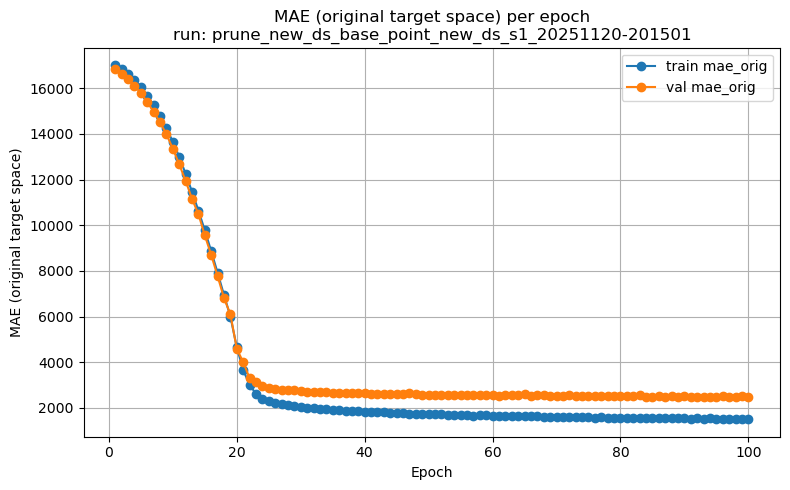

In [4]:
# === Cell: Plot train vs validation curve for a selected metric ===
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# User config
# ------------------------------------------------------------------
# 1) Training run directory: folder that contains metrics.csv
RUN_DIR = Path(
    r"Z:\uncertainty_quantification\outputs\trainings\training_prune2_new_ds_base_point_20251120-1706\prune_new_ds_base_point_new_ds_s1_20251120-201501"
)  # <-- change to the run you want

# Z:\uncertainty_quantification\outputs\trainings\training_gaussian_20251120-2143\gaussian_explore_s1_20251121-082024
# Z:\uncertainty_quantification\outputs\trainings\training_prune2_new_ds_base_point_20251120-1706\prune_new_ds_base_point_new_ds_s1_20251120-201501

# 2) Metric selector:
#    Supported:
#      "loss"        -> training/validation loss (head-specific; log-space)
#      "mae"         -> MAE on transformed/log-space target
#      "rmse"        -> RMSE on transformed/log-space target
#      "mse"         -> derived from rmse**2
#      "mae_orig"    -> MAE on original target space (after inverse transform)
#      "rmse_orig"   -> RMSE on original target space
#      "mse_orig"    -> derived from rmse_orig**2
#      "nll"         -> mean NLL (for gauss/laplace heads; may be 0 for point)
METRIC = "mae_orig"

# Pretty y-labels
USE_VERBOSE_LABELS = True

# ------------------------------------------------------------------
# Load and prepare metrics
# ------------------------------------------------------------------
csv_path = RUN_DIR / "metrics.csv"
if not csv_path.is_file():
    raise FileNotFoundError(f"metrics.csv not found at: {csv_path}")

df = pd.read_csv(csv_path)

# Handle derived metrics
derived_map = {
    "mse": "rmse",
    "mse_orig": "rmse_orig",
}
if METRIC in derived_map:
    base = derived_map[METRIC]
    if base not in df.columns:
        raise ValueError(
            f"Cannot derive '{METRIC}' because base column '{base}' "
            f"is missing from metrics.csv. Available columns: {list(df.columns)}"
        )
    # ensure numeric then derive
    df[base] = pd.to_numeric(df[base], errors="coerce")
    df[METRIC] = df[base] ** 2
else:
    if METRIC not in df.columns:
        raise ValueError(
            f"Metric '{METRIC}' not found in metrics.csv. "
            f"Available columns: {list(df.columns)}"
        )
    df[METRIC] = pd.to_numeric(df[METRIC], errors="coerce")

# Keep only train/val rows and drop NaNs for the selected metric
df_plot = df[df["split"].isin(["train", "val"])].copy()
df_plot = df_plot.dropna(subset=[METRIC])

train = df_plot[df_plot["split"] == "train"]
val = df_plot[df_plot["split"] == "val"]

# ------------------------------------------------------------------
# Plot
# ------------------------------------------------------------------
plt.figure(figsize=(8, 5))

if not train.empty:
    plt.plot(
        train["epoch"], train[METRIC],
        label=f"train {METRIC}",
        marker="o",
    )
if not val.empty:
    plt.plot(
        val["epoch"], val[METRIC],
        label=f"val {METRIC}",
        marker="o",
    )

metric_label_map = {
    "loss": "Training loss (head-specific)",
    "mae": "MAE (model output space)",
    "rmse": "RMSE (model output space)",
    "mse": "MSE (model output space)",
    "mae_orig": "MAE (original target space)",
    "rmse_orig": "RMSE (original target space)",
    "mse_orig": "MSE (original target space)",
    "nll": "Negative log-likelihood",
}
ylabel = metric_label_map.get(METRIC, METRIC) if USE_VERBOSE_LABELS else METRIC

plt.xlabel("Epoch")
plt.ylabel(ylabel)
plt.title(f"{ylabel} per epoch\nrun: {RUN_DIR.name}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
